In [8]:
import pandas as pd

df = pd.read_json("/content/problems_data.jsonl", lines=True)
df.head()
df.info()
df['problem_class'].value_counts()
df['problem_score'].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   sample_io           4112 non-null   object 
 5   problem_class       4112 non-null   object 
 6   problem_score       4112 non-null   float64
 7   url                 4112 non-null   object 
dtypes: float64(1), object(7)
memory usage: 257.1+ KB


,problem_score
count,4112.000000
mean,5.114689
std,2.177770
min,1.100000
25%,3.300000
50%,5.200000
75%,6.900000
max,9.700000


In [9]:
df['text'] = (
    df['title'].fillna('') + " " +
    df['description'].fillna('') + " " +
    df['input_description'].fillna('') + " " +
    df['output_description'].fillna('')
)


In [10]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

df['text'] = df['text'].apply(clean_text)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(df['text'])


In [12]:
import numpy as np

keywords = ['dp', 'graph', 'tree', 'recursion', 'binary search', 'greedy']

def keyword_count(text):
    return sum(text.count(k) for k in keywords)

df['text_len'] = df['text'].apply(len)
df['math_symbols'] = df['text'].apply(lambda x: sum(1 for c in x if c in "=<>+-*/"))
df['keyword_count'] = df['text'].apply(keyword_count)


In [13]:
from scipy.sparse import hstack

X_extra = df[['text_len', 'math_symbols', 'keyword_count']].values
X = hstack([X_tfidf, X_extra])


In [14]:
from sklearn.model_selection import train_test_split

y_class = df['problem_class']
y_score = df['problem_score']

X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

_, _, y_score_train, y_score_test = train_test_split(
    X, y_score, test_size=0.2, random_state=42
)


In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=5000,
    solver='saga',
    class_weight='balanced',
    n_jobs=-1
)

clf.fit(X_train, y_class_train)

clf.classes_



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array(['easy', 'hard', 'medium'], dtype=object)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)

acc = accuracy_score(y_class_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.5164034021871203


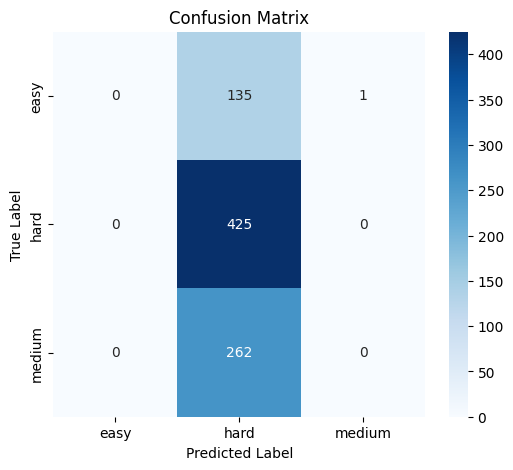

In [17]:
cm = confusion_matrix(y_class_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [18]:
print(classification_report(y_class_test, y_pred))


              precision    recall  f1-score   support

        easy       0.00      0.00      0.00       136
        hard       0.52      1.00      0.68       425
      medium       0.00      0.00      0.00       262

    accuracy                           0.52       823
   macro avg       0.17      0.33      0.23       823
weighted avg       0.27      0.52      0.35       823



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

from scipy.sparse import hstack

tfidf = TfidfVectorizer(
    max_features=4000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3
)

X_tfidf = tfidf.fit_transform(df['text'])


In [20]:
df['text_len'] = df['text'].apply(len)
df['text_len_log'] = np.log1p(df['text_len'])


keywords = [
    'dp', 'dynamic programming', 'graph', 'tree',
    'dfs', 'bfs', 'recursion', 'binary search', 'greedy'
]

def keyword_count(text):
    return sum(text.count(k) for k in keywords)

df['keyword_count'] = df['text'].apply(keyword_count)

math_symbols = r"[=<>+\-*/%]"

def math_symbol_density(text):
    if len(text) == 0:
        return 0
    return len(re.findall(math_symbols, text)) / len(text)

df['math_density'] = df['text'].apply(math_symbol_density)




In [21]:
X_extra = df[['text_len_log', 'keyword_count', 'math_density']].values

scaler = StandardScaler(with_mean=False)
X_extra_scaled = scaler.fit_transform(X_extra)


In [22]:
X = hstack([X_tfidf, X_extra_scaled])
y = df['problem_class']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [24]:
svm_clf = LinearSVC(
    C=1.0,
    class_weight='balanced'
)

svm_clf.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced')

In [25]:
y_pred = svm_clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        easy       0.37      0.44      0.40       153
        hard       0.55      0.59      0.57       389
      medium       0.38      0.31      0.34       281

    accuracy                           0.46       823
   macro avg       0.43      0.44      0.44       823
weighted avg       0.46      0.46      0.46       823



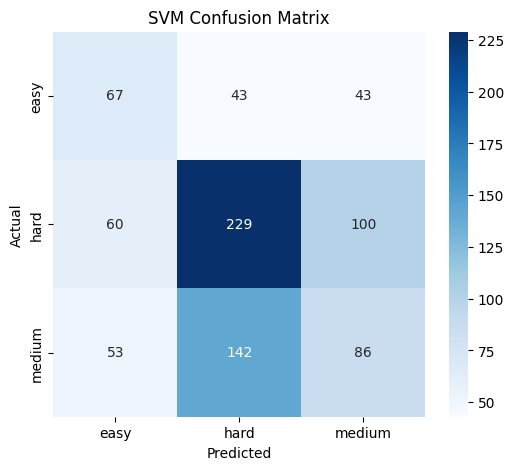

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=svm_clf.classes_,
    yticklabels=svm_clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_nb = TfidfVectorizer(
    max_features=4000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3
)

X_nb = tfidf_nb.fit_transform(df['text'])
y = df['problem_class']


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_nb,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [29]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB(alpha=0.5)  # alpha = smoothing
nb_clf.fit(X_train, y_train)


MultinomialNB(alpha=0.5)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = nb_clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        easy       0.50      0.18      0.27       153
        hard       0.51      0.77      0.61       389
      medium       0.38      0.25      0.30       281

    accuracy                           0.48       823
   macro avg       0.46      0.40      0.39       823
weighted avg       0.47      0.48      0.44       823



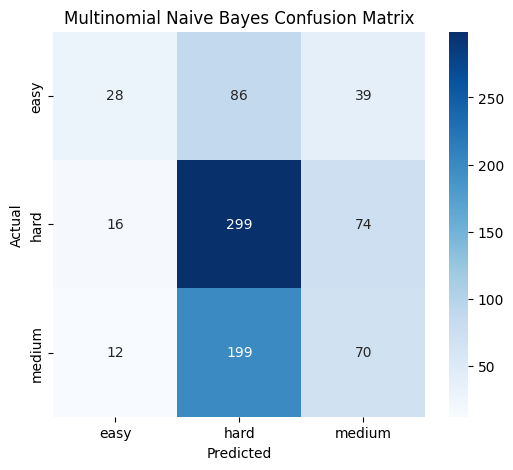

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=nb_clf.classes_,
    yticklabels=nb_clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.show()


In [32]:
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.sparse import hstack

tfidf = TfidfVectorizer(
    max_features=4000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3
)

X_tfidf = tfidf.fit_transform(df['text'])


In [33]:
# log text length
df['text_len_log'] = np.log1p(df['text'].apply(len))

# keyword count
keywords = [
    'dp', 'dynamic programming', 'graph', 'tree',
    'dfs', 'bfs', 'recursion', 'binary search', 'greedy'
]

df['keyword_count'] = df['text'].apply(
    lambda x: sum(x.count(k) for k in keywords)
)

# math symbol density
math_symbols = r"[=<>+\-*/%]"
df['math_density'] = df['text'].apply(
    lambda x: len(re.findall(math_symbols, x)) / len(x) if len(x) > 0 else 0
)


In [34]:
X_extra = df[['text_len_log', 'keyword_count', 'math_density']].values

scaler = StandardScaler(with_mean=False)
X_extra_scaled = scaler.fit_transform(X_extra)

X = hstack([X_tfidf, X_extra_scaled])
y = df['problem_score']


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [36]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train.toarray(), y_train)


RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [37]:
y_pred = rf_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 1.6963844968489958
RMSE: 2.039589898011407


In [38]:
df['problem_score'].describe()


,problem_score
count,4112.000000
mean,5.114689
std,2.177770
min,1.100000
25%,3.300000
50%,5.200000
75%,6.900000
max,9.700000


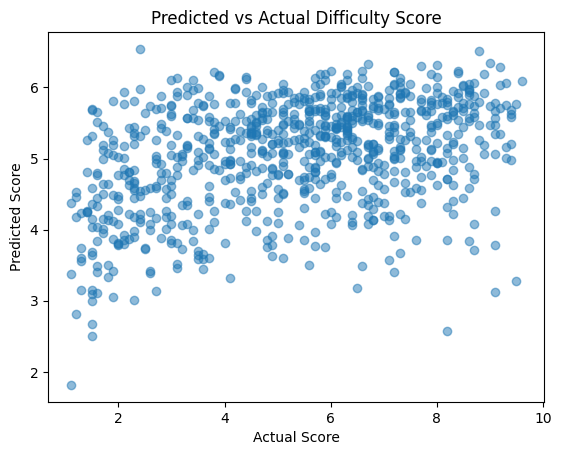

In [39]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Difficulty Score")
plt.show()


In [40]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from scipy.sparse import hstack

tfidf = TfidfVectorizer(
    max_features=4000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3
)

X_tfidf = tfidf.fit_transform(df['text'])


In [41]:
X_extra = df[['text_len_log', 'keyword_count', 'math_density']].values

scaler = StandardScaler(with_mean=False)
X_extra_scaled = scaler.fit_transform(X_extra)

X = hstack([X_tfidf, X_extra_scaled])
y = df['problem_score']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [43]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train.toarray(), y_train)


GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

In [44]:
y_pred = gbr.predict(X_test.toarray())

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Gradient Boosting MAE:", mae)
print("Gradient Boosting RMSE:", rmse)


Gradient Boosting MAE: 1.6986907742731197
Gradient Boosting RMSE: 2.037571384170186


In [45]:
print("Random Forest   → MAE: 1.696 | RMSE: 2.040")
print(f"Gradient Boost  → MAE: {mae:.3f} | RMSE: {rmse:.3f}")


Random Forest   → MAE: 1.696 | RMSE: 2.040
Gradient Boost  → MAE: 1.699 | RMSE: 2.038


In [46]:
import joblib
joblib.dump(svm_clf, "svm_classifier.pkl")
joblib.dump(tfidf, "tfidf_classifier.pkl")


['tfidf_classifier.pkl']

In [47]:
joblib.dump(rf_reg, "rf_regressor.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(tfidf, "tfidf_regressor.pkl")


['tfidf_regressor.pkl']

In [48]:
import os

os.listdir()


['.config',
 'tfidf_regressor.pkl',
 'feature_scaler.pkl',
 'tfidf_classifier.pkl',
 'problems_data.jsonl',
 'rf_regressor.pkl',
 'svm_classifier.pkl',
 '.ipynb_checkpoints']